© 2025 Zitao Yang, Rebecca J. Rousseau, Sara D. Mahdavi, Hernan G. Garcia, and Rob Phillips, *The Dynamics of Inducible Genetic Circuits*. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).
___

# Dynamics of the Feed-Forward Loop (FFL)

This notebook generates the results shown in Figures 21, 22, 24, and 25, as well as Appendix Figures 35 - 37 of the paper, which evaluate how coherent and incoherent feed-forward loop output expression $\bar{Z}$ responds to changes in input expression $\bar{X}$.

## General helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Figure formatting

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    'mathtext.fontset': 'stix',
    "font.family": 'STIXGeneral',
    "axes.labelpad": 8.0
})

# Helper functions

def pAct(C, Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):
    """ Probability of repressor/activator being active
    
    Arguments:
        - C: effector concentration
        - Ka: dissociation constant in active state
        - Ki: dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p = (1 + C/Ka)**2 / ((1 + C/Ka)**2 + np.exp(-delE)*(1 + C/Ki)**2)
    return p

def normalize(x):
    """ Normalize an array such that 
    min(x) = 0
    max(x) = 1
    """
    return (x - min(x)) / (max(x) - min(x))

def normalize_pulse(x, xmax, xmin):
    """ Normalize an array such that 
    min(x) = xmin
    max(x) = xmax
    useful when the trajectory exhibits a pulse
    """
    print(xmin, xmax)
    return (x - xmin) / (xmax - xmin)

# Main text figures

# Fig. 21(A)

This figure plots the delay observed in the coherent feed-forward loop vs. simple regulation in response to a pulse in input signal.

### Helper functions

In [2]:
def steadyStateFeedForward(X, rys, rzs, w, px, py, Ks):
    """ Find the coherent FFL steady states given parameters

    Arguments:
        - X: dimensionless concentration of X
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
            
    Returns: steady state concentrations
    """

    Kxy, Kxz, Kyz = Ks

    Y = (rys[0] + rys[1]*px*X/Kxy)/(1 + px*X/Kxy)
    Z = (rzs[0] + rzs[1]*(px*X/Kxz + py*Y/Kyz) +\
                             w*rzs[2]*px*X/Kxz*py*Y/Kyz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)

    if type(Y) is np.float64:
        return np.array([X, Y, Z])
    else:
        Xarray = np.full_like(Y, X)
        return [Xarray, Y, Z]

def steadyStateSimpleReg(X, Y, rzs, w, px, py, Ks):
    """ Find the coherent simple regulation steady states given parameters

    Arguments:
        - X: dimensionless concentration of X
        - Y: dimensionless concentration of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (Kxy does not act)

    Returns: steady state concentrations
    """

    Kxy, Kxz, Kyz = Ks
    
    Z = (rzs[0] + rzs[1]*(px*X/Kxz + py*Y/Kyz) +\
                             w*rzs[2]*px*X/Kxz*py*Y/Kyz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)
    
    return np.array([X, Y, Z])

def evolveFeedForward(Rs, rys, rzs, w, px, py, delt, Ks):
    """ Numerically evolve coherent FFL dynamics

    Arguments:
        - Rs: current concentrations [X, Y, Z]
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - delt: size of time step
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
    
    Returns: updated concentrations
    """

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    # dY/dt
    dRsdt[1] = - Rs[1] + (rys[0] + rys[1]*px*Rs[0]/Kxy)/(1 + px*Rs[0]/Kxy)
    # dZ/dt
    dRsdt[2] = - Rs[2] + (rzs[0] + rzs[1]*(px*Rs[0]/Kxz + py*Rs[1]/Kyz) +\
                             w*rzs[2]*px*Rs[0]/Kxz*py*Rs[1]/Kyz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    # Linearly evolve the system
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def evolveSimpleReg(Rs, rys, rzs, w, px, py, delt, Ks):
    """ Numerically evolve coherent simple regulation dynamics

    Arguments:
        - Rs: current concentrations [X, Y, Z]
        - rys: does not act
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - delt: size of time step
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (Kxy does not act)

    Returns: updated concentrations
    """

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    activation = (rzs[0] + rzs[1]*(px*Rs[0]/Kxz + py*Rs[1]/Kyz) +\
                             w*rzs[2]*px*Rs[0]/Kxz*py*Rs[1]/Kyz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    dRsdt[2] = - Rs[2] + activation
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

In [3]:
def integrate_coherent_step(rys, rzs, w, Ks, nstep=3*10**4, delt=10**(-3), 
                           pmin=pAct(10**(-4)), pmax=pAct(10**(-7)), X=1, Y=1):
    """ Numerically integrate coherent FFL dynamics
    when the signal is a step function

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
        - nstep: number of time steps
        - delt: size of time step
        - pmin: low value of pact^X
        - pmax: high value of pact^X
        - X: dimensionless concentration of X
        - Y: dimensionless concentration of Y
            (for simple regulation)
    """

    ts = np.linspace(0, nstep*delt, nstep)

    # Define how effector concentration is tuned
    empty = np.full(int(nstep/5), pmin)
    full = np.full(int(nstep/5), pmax)

    pxs = np.concatenate((empty, full, full, empty, empty))
    pys = np.full(nstep, pmax)

    # History of FFL concentrations
    Rs = np.zeros((nstep, 3))
    Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

    # History of simple regulation concentrations
    Rps = np.copy(Rs)
    Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

    # Evolve the system
    for i in range(nstep-1):
        
        px = pxs[i]
        py = pys[i]

        Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
        Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

    # Plot the trajectories
    fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

    axs[0].plot(ts, pxs, c="C3", label=r"$p_{act}^X$")
    axs[0].plot(ts, pys, c="C4", label=r"$p_{act}^Y$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

    axs[1].plot(ts, Rs[:, 2], label=r"feed-forward loop")
    axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"simple regulation")
    axs[1].set_xlabel(r"dimensionless time, $\bar{t}$")
    axs[1].set_ylabel(r"output concentration, $\bar{Z}$")
    axs[1].legend()
    fig.align_labels()
    plt.show()

### (A): Example coherent feed-forward loop response trajectory

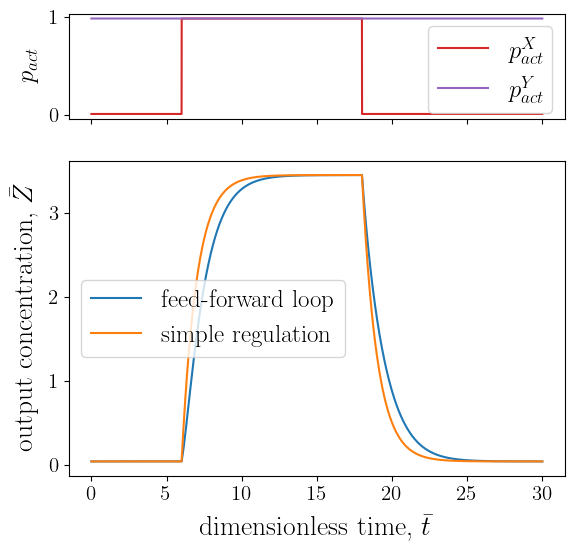

In [4]:
rys = [0, 2]
rzs = [0, 2, 10]
w = 1
Ks = [1, 1, 1]

integrate_coherent_step(rys, rzs, w, Ks)

# Fig. 22

This figure plots the magnitude of the average time delay, $|\langle\Delta\bar{t}\rangle|$, observed across parameter space in the ON and OFF steps of different coherent feed-forward logic gates.

### Helper functions

Note that `delY`$ = \mathcal{Y}_i - \mathcal{Y}_f$ in all functions in this notebook, which is in fact $-\Delta \mathcal{Y}$ as defined in the paper.

In [5]:
def diff_func(ts, rs, w, X, delY, Yinf):
    """ Compute the difference in output expression between coherent FFL and simple regulation as a function of time,
    also known as Theta(t)

    Arguments:
        - ts: time samples
        - rs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - X: mathcal X, rescaled concentration of X
        - delY: (mathcal Y_i - mathcal Y_f) 
            rescaled difference between initial and final concentrations of Y
        - Yinf: mathcal Y_f
            rescaled final concentration of Y

    Returns: Theta(t)
    """

    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    chi = (r1 + r2*w*X*(1 + X)) - (r0*(1 + w*X) + r1*w*X**2)
    
    return np.exp(-ts)*(chi*delY/S**2)*np.log((S*np.exp(ts) + delY*(1 + w*X))/(S + delY*(1 + w*X)))

def int_delta(rs, w, X, delY, Yinf):
    """ Compute the integral of Theta(t); once normalized, this will reflect the average delay in expression
    for the coherent FFL compared to simple regulation. Note that this function explicitly calculates the value
    for Theta(t) from the integrated result defined in Section IV(A) of the paper.

    Arguments:
        - rs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - X: mathcal X, rescaled concentration of X
        - delY: (mathcal Y_i - mathcal Y_f) 
            rescaled difference between initial and final concentrations of Y
        - Yinf: mathcal Y_f
            rescaled final concentration of Y
    
    Returns: Integral of Theta(t) from t=0 to infinity
    """

    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    Phi = (r1 + r2*w*X*(1 + X)) - (r0*(1 + w*X) + r1*w*X**2)
    return Phi/(S*(1 + w*X))*np.log(1 + delY * (1+w*X) / S)

In [6]:
def delt_colormap_ON(rys, rzs, w, Kxzs, Kyzs, plow=pAct(10**(-4)), phigh=pAct(10**(-7)), X=1, plot=True):
    """ Sweep in (KXZ, KYZ) space and compute average time delay
    for an ON step

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - Kxzs: array of Kxz to be swept
        - Kyzs, array of Kyz to be swept
        - plow: low value of pact^X
        - phigh: high value of pact^X
        - X: dimensionless concentration of X
        - plot: whether to plot the heatmap
    """
    # Create 2d mesh  
    KX, KY = np.meshgrid(Kxzs, Kyzs)
    KXY = np.full_like(KX, 1)
    Ks = [KXY, KX, KY]

    Xs = np.full_like(KX, X)

    # Compute initial and final FFL steady states
    [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
    [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

    # Compute average time delay
    delta = np.abs(int_delta(rzs, w, phigh*X/KX, (lowY - highY)/KY, highY/KY))
    timescale = delta/(highZ - lowZ)

    if plot:
        fig, ax = plt.subplots()
        im = ax.pcolormesh(KX, KY, timescale, cmap="Greens", rasterized = True, vmin=0, vmax=1.05)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel(r"$\bar{K}_{XZ}$")
        ax.set_ylabel(r"$\bar{K}_{YZ}$")
        cbar = plt.colorbar(im)
        cbar.set_label(r"$\langle \Delta \bar{t} \rangle$")
        plt.show()
    return np.max(timescale)

def delt_colormap_OFF(rys, rzs, w, Kxzs, Kyzs, plow=pAct(10**(-4)), phigh=pAct(10**(-7)), X=1, plot=True):
    """ Sweep in (KXZ, KYZ) space and compute average time delay
    for an OFF step

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - Kxzs: array of Kxz to be swept
        - Kyzs, array of Kyz to be swept
        - plow: low value of pact^X
        - phigh: high value of pact^X
        - X: dimensionless concentration of X
        - plot: whether to plot the heatmap
    """

    # Create 2d mesh

    KX, KY = np.meshgrid(Kxzs, Kyzs)
    KXY = np.full_like(KX, 1)
    Ks = [KXY, KX, KY]

    Xs = np.full_like(KX, X)

    # Compute initial and final FFL steady states
    [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
    [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

    # Compute average time delay
    delta = np.abs(int_delta(rzs, w, plow*X/KX, (highY - lowY)/KY, lowY/KY))
    timescale = delta/(highZ - lowZ)

    if plot:
        fig, ax = plt.subplots()
        im = ax.pcolormesh(KX, KY, timescale, cmap="Greens", rasterized = True, vmin=0, vmax=4.5)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel(r"$\bar{K}_{XZ}$")
        ax.set_ylabel(r"$\bar{K}_{YZ}$")
        cbar = plt.colorbar(im)
        cbar.set_label(r"$\langle \Delta \bar{t} \rangle$")
        plt.show()
    return np.max(timescale)

### (A)(i, ii): XOR gate

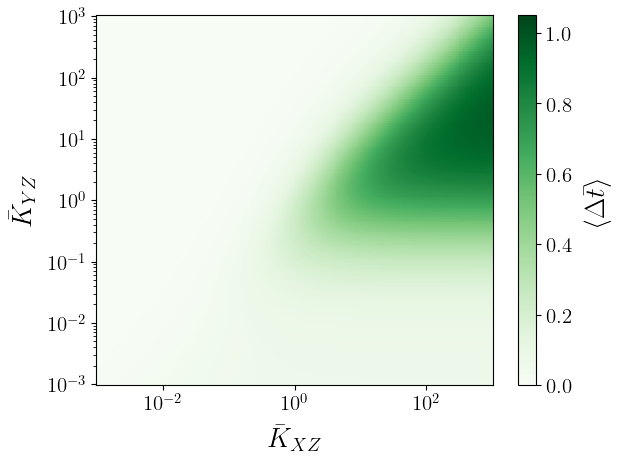

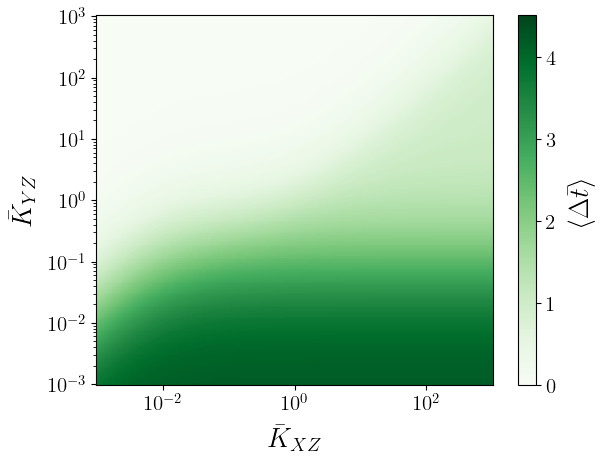

In [7]:
# XOR GATE, (i) ON STEP, (ii) OFF STEP

rys = [0, 2]
rzs = [0, 2, 0]
w = 0

length = 200

# Create 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

delt_colormap_ON(rys, rzs, w, Kxzs, Kyzs)
delt_colormap_OFF(rys, rzs, w, Kxzs, Kyzs)
plt.show()

### (B)(i, ii): AND gate

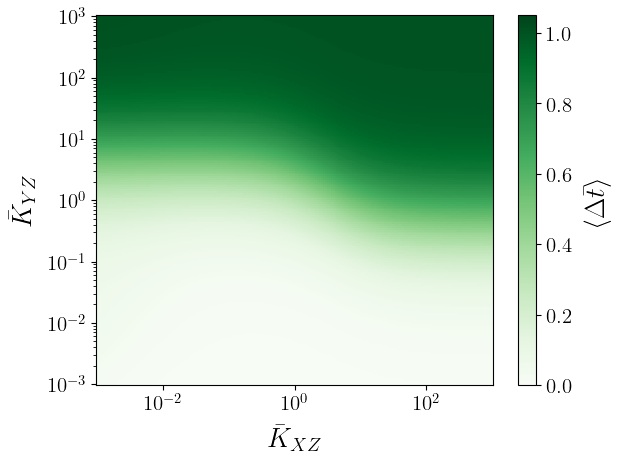

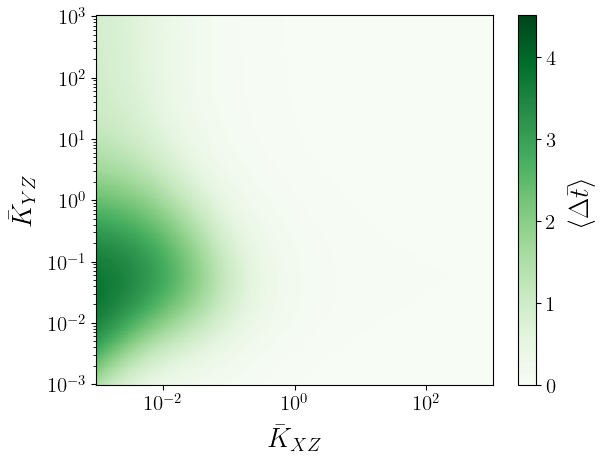

In [8]:
# AND GATE, (i) ON STEP, (ii) OFF STEP

rys = [0, 2]
rzs = [0, 0, 2]
w = 10

length = 200

# Create 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

delt_colormap_ON(rys, rzs, w, Kxzs, Kyzs)
delt_colormap_OFF(rys, rzs, w, Kxzs, Kyzs)
plt.show()

### (C)(i, ii): OR gate

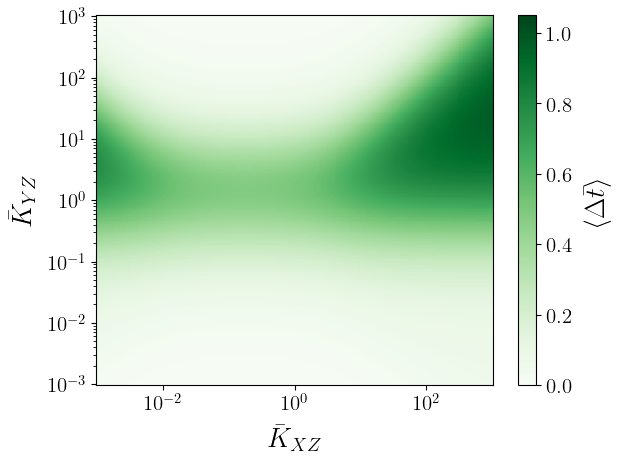

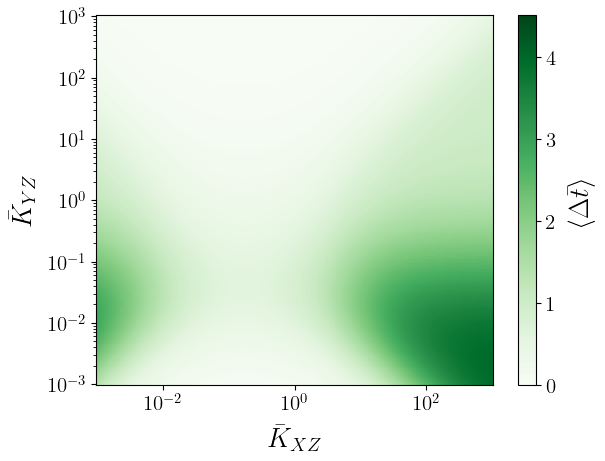

In [9]:
# OR GATE, (i) ON STEP, (ii) OFF STEP

rys = [0, 2]
rzs = [0, 2, 10]
w = 1

length = 200

# Create 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

delt_colormap_ON(rys, rzs, w, Kxzs, Kyzs)
delt_colormap_OFF(rys, rzs, w, Kxzs, Kyzs)
plt.show()

### (A-C)(iii): Specific trajectories

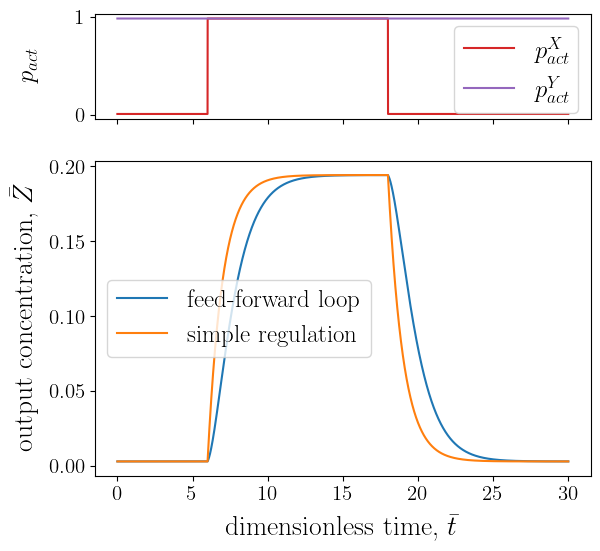

In [10]:
# (A) - XOR gate

rys = [0, 2]
rzs = [0, 2, 0]
w = 0
Ks = [1, 10**2, 10]

integrate_coherent_step(rys, rzs, w, Ks)

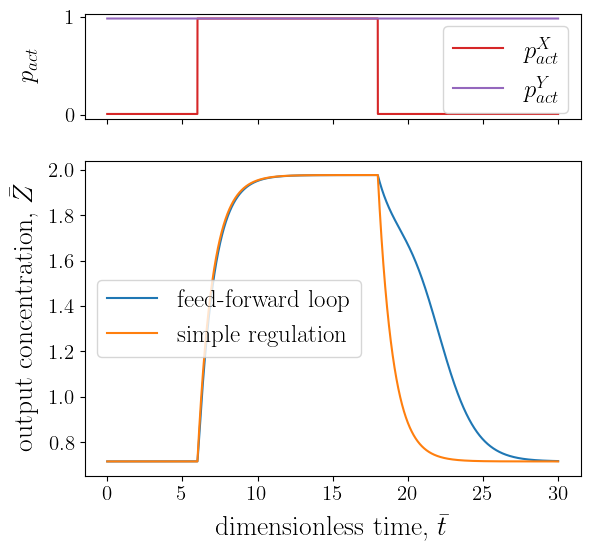

In [11]:
# (B) - AND gate

rys = [0, 2]
rzs = [0, 0, 2]
w = 10
Ks = [1, 10**(-2), 10**(-1)]

integrate_coherent_step(rys, rzs, w, Ks)

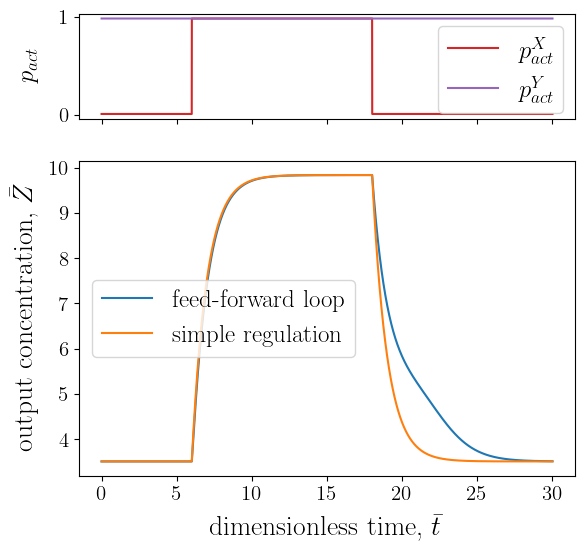

In [12]:
# (C) - OR gate

rys = [0, 2]
rzs = [0, 2, 10]
w = 1
Ks = [1, 10**(-2), 10**(-2)]

integrate_coherent_step(rys, rzs, w, Ks)

# Fig. 24

This figure plots output response to an input signal switching "ON" in the incoherent feed-forward loop, demonstrating the existence of a pulse and acceleration in response compared to simple regulation under different parameter conditions.

### Helper functions

In [13]:
def steadyStateFeedForwardIncoh(X, rys, rzs, w, px, py, Ks):
    """ Find the incoherent FFL steady states given parameters

    Arguments:
        - X: dimensionless concentration of X
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
            
    Returns: steady state concentrations
    """

    Kxy, Kxz, Kyz = Ks

    Y = (rys[0] + rys[1]*px*X/Kxy)/(1 + px*X/Kxy)
    Z = (rzs[0] + rzs[1]*px*X/Kxz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)

    return np.array([X, Y, Z])

def steadyStateSimpleRegIncoh(X, Y, rzs, w, px, py, Ks):
    """ Find the incoherent simple regulation steady states given parameters

    Arguments:
        - X: dimensionless concentration of X
        - Y: dimensionless concentration of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (Kxy does not act)

    Returns: steady state concentrations
    """

    Kxy, Kxz, Kyz = Ks
    
    Z = (rzs[0] + rzs[1]*px*X/Kxz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)
    
    return np.array([X, Y, Z])

def evolveFeedForwardIncoh(Rs, rys, rzs, w, px, py, delt, Ks):
    """ Numerically evolve incoherent FFL dynamics

    Arguments:
        - Rs: current concentrations [X, Y, Z]
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - delt: size of time step
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
    
    Returns: updated concentrations
    """

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    dRsdt[1] = - Rs[1] + (rys[0] + rys[1]*px*Rs[0]/Kxy)/(1 + px*Rs[0]/Kxy)
    dRsdt[2] = - Rs[2] + (rzs[0] + rzs[1]*px*Rs[0]/Kxz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def evolveSimpleRegIncoh(Rs, rys, rzs, w, px, py, delt, Ks):
    """ Numerically evolve incoherent simple regulation dynamics

    Arguments:
        - Rs: current concentrations [X, Y, Z]
        - rys: does not act
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - px: pact^X, probability of X being active
        - py: pact^Y, probability of Y being active
        - delt: size of time step
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (Kxy does not act)

    Returns: updated concentrations
    """

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    dRsdt[2] = - Rs[2] + (rzs[0] + rzs[1]*px*Rs[0]/Kxz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def diff_func_incoh(ts, rs, w, X, delY, Yinf):
    """ Compute the difference between incoherent FFL and simple regulation,
    also known as Theta(t)

    Arguments:
        - ts: time samples
        - rs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - X: mathcal X, rescaled concentration of X
        - delY: (mathcal Y_i - mathcal Y_f) 
            rescaled difference between initial and final concentrations of Y
        - Yinf: mathcal Y_f
            rescaled final concentration of Y

    Returns: Theta(t)
    """

    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    Phi = -(r0 + r1*X)*(1 + w*X)
    
    return np.exp(-ts)*(Phi*delY/S**2)*np.log((S*np.exp(ts) + delY*(1 + w*X))/(S + delY*(1 + w*X)))

def int_delta_incoh(rs, w, X, delY, Yinf):
    """ Compute the integral of Theta(t), for incoherent FFL

    Arguments:
        - rs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - X: mathcal X, rescaled concentration of X
        - delY: (mathcal Y_i - mathcal Y_f) 
            rescaled difference between initial and final concentrations of Y
        - Yinf: mathcal Y_f
            rescaled final concentration of Y
    
    Returns: Integral of Theta(t) from t=0 to infinity
    """

    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    Phi = -(r0 + r1*X)*(1 + w*X)

    return Phi/(S*(1 + w*X))*np.log(1 + delY * (1 + w*X) / S)

In [14]:
def integrate_incoherent_curve(rys, rzs, w, Ks, nstep=int(1.5*10**4), delt=10**(-3), 
                           pmin=pAct(10**(-4)), pmax=pAct(10**(-7)), X=1, Y=1):
    """ Numerically integrate incoherent FFL dynamics,
    when the signal is a step function

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
            (note r2Z does not act as it doesn't exist
            for incoherent FFL)
        - w: cooperativity
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
        - nstep: number of steps
        - delt: size of time step
        - pmin: low value of pact^X
        - pmax: high value of pact^X
        - X: dimensionless concentration of X
        - Y: dimensionless concentration of Y
            (for simple regulation)
    """

    ts = np.linspace(0, nstep*delt, nstep)

    # Define how effector concentration is tuned
    empty = np.full(int(nstep/5), pmin)
    full = np.full(int(nstep/5), pmax)

    pxs = np.concatenate((empty, full, full, full, full))
    pys = np.full(nstep, pmax)

    # History of incoherent FFL concentrations    
    Rs = np.zeros((nstep, 3))
    Rs[0, :] = steadyStateFeedForwardIncoh(X, rys, rzs, w, pxs[0], pys[0], Ks)

    # History of simple regulation concentrations
    Rps = np.copy(Rs)
    Rps[0, :] = steadyStateSimpleRegIncoh(X, Y, rzs, w, pxs[0], pys[0], Ks)

    # Evolve the system
    for i in range(nstep-1):
        
        px = pxs[i]
        py = pys[i]

        Rs[i+1, :] = evolveFeedForwardIncoh(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
        Rps[i+1, :] = evolveSimpleRegIncoh(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

    Zmax = steadyStateFeedForwardIncoh(X, rys, rzs, w, pmax, pmax, Ks)[2]
    Zmin = steadyStateFeedForwardIncoh(X, rys, rzs, w, pmin, pmax, Ks)[2]

    # Plot the trajectories    
    fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

    axs[0].plot(ts, pxs, c="C3", label=r"$p_{act}^X$")
    axs[0].plot(ts, pys, c="C4", label=r"$p_{act}^Y$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])
    
    axs[1].plot(ts, Rs[:, 2], label=r"feed-forward loop")
    axs[1].plot(ts, normalize(Rps[:, 2])*np.abs(Zmax - Zmin) + np.min([Zmax, Zmin]), label=r"simple regulation")
    axs[1].set_xlabel(r"dimensionless time, $\bar{t}$")
    axs[1].set_ylabel(r"output concentration, $\bar{Z}$")
    axs[1].legend()
    fig.align_labels()
    plt.show()

### (A), (B): Acceleration / pulse strength sweeps

Panels (A) and (B) of Fig. 24 in the paper quantify the difference in response to an input signal ON step for the incoherent FFL vs. simple regulation.

Panel (A) specifically focuses on $(\bar{K}_{YZ}, \bar{K}_{XZ})$ parameter space for which no strong pulse is observed. This plot then quantifies the difference by computing the magnitude of the average acceleration, $|\langle\Delta\bar{t}\rangle|$, across parameter space.

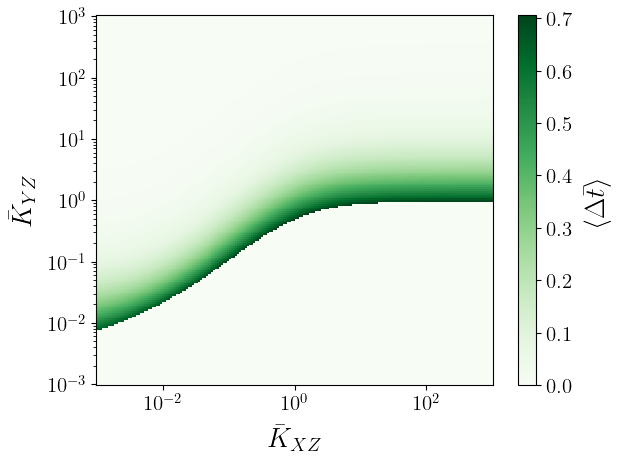

In [15]:
# Define system parameters
nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 0]
w = 0

length = 200
plow = pAct(10**(-4))
phigh = pAct(10**(-7))

X = 1

# Create 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

# Compute initial and final steady states
[_, lowY, lowZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForwardIncoh(Xs, rys, rzs, w, phigh, phigh, Ks)

# Maximal Z concentration reached by a trajectory
max_Z = np.zeros_like(KX)

for i in range(length):
    for j in range(length):
        # find maximal Z concentration given (KXZ, KYZ)
        diff = diff_func_incoh(ts, rzs, w, phigh*X/KX[i, j], (lowY[i, j] - highY[i, j])/KY[i, j], highY[i, j]/KY[i, j])
        max_Z[i, j] = np.max(diff + lowZ[i, j]*np.exp(-ts) + highZ[i, j]*(1 - np.exp(-ts)))

# Height of pulse
pulse_val = (max_Z - highZ)
# Delta Z
Zdiff = highZ - lowZ
# Area between curves
delta_mag = int_delta_incoh(rzs, w, phigh*X/KX, (lowY - highY)/KY, highY/KY)
# Set relative threshold
threshold = 0.05

# Only consider time acceleration for the non strong pulses: if the maximum output expression observed exceeds
# steady state output expression by the threshold defined, then this is considered a strong pulse and appears
# as zero in the plot below
time_acceleration = delta_mag/Zdiff
time_acceleration[pulse_val > threshold*Zdiff] = 0

# Plot
fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, time_acceleration, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\bar{K}_{XZ}$")
ax.set_ylabel(r"$\bar{K}_{YZ}$")
# ax.contour(KX, KY, pulse_val > threshold*Zdiff, levels=1)
cbar = plt.colorbar(im)
cbar.set_label(r"$\langle\Delta\bar{t} \rangle$")
plt.show()

Note that below the observed contour the system is considered to have a "strong pulse."

Panel (B) of Fig. 24 in the paper focuses specifically on the region of parameter space exhibiting a "strong pulse," and quantifies the amplitude of the pulse observed above steady state expression $\bar{Z}_{f}$.

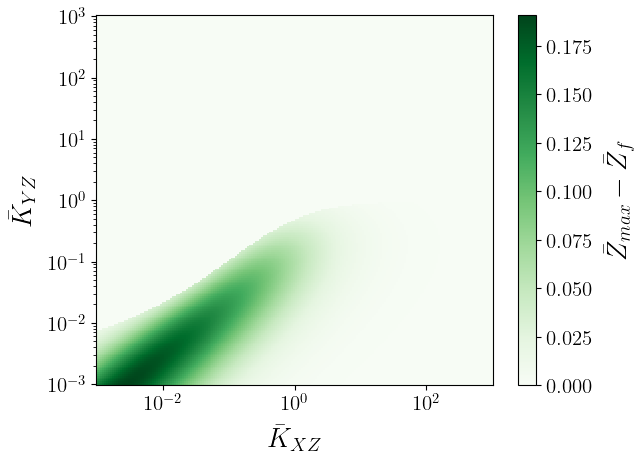

In [16]:
# Only consider pulse values for the strong pulses
pulse_val[pulse_val < threshold*Zdiff] = 0

fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, pulse_val, cmap="Greens", rasterized = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\bar{K}_{XZ}$")
ax.set_ylabel(r"$\bar{K}_{YZ}$")
#ax.contour(KX, KY, pulse_val > threshold*Zdiff, levels=1)
cbar = plt.colorbar(im)
cbar.set_label(r"$\bar{Z}_{max} - \bar{Z}_f$")
plt.show()

Note that above the contour previously observed in Panel (A), the system is considered to have a "not-strong pulse" and is therefore set to zero in the heatmap. To explicitly plot this contour separating the regions of strong and non-strong pulse in the paper figure, the (commented) command `ax.contour(KX, KY, pulse_val > threshold*Zdiff, levels=1)` may be used. For aesthetic reasons we do not use it, and instead equivalently trace the curve in Adobe Illustrator.

### (C), (D): Example trajectories

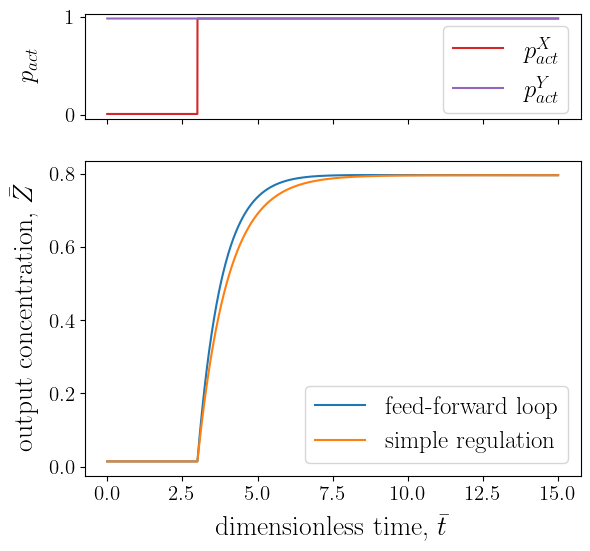

In [17]:
# (C): An example output response curve with accelerated response from the incoherent FFL but no pulse

rys = [0, 2]
rzs = [0, 2, 0]
w = 0
Ks = [1, 1, 2]

integrate_incoherent_curve(rys, rzs, w, Ks)

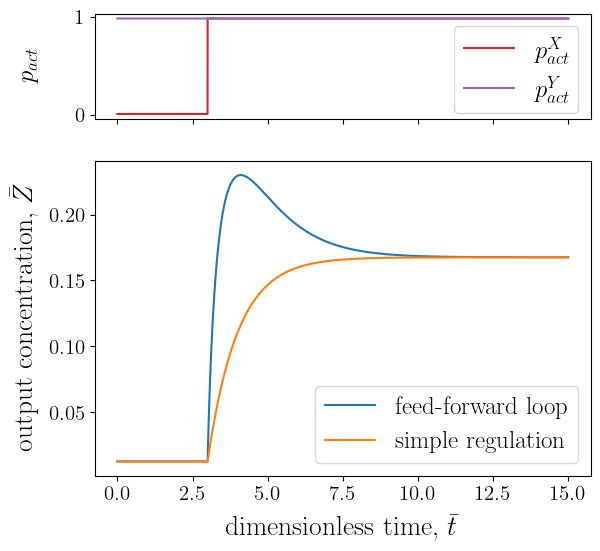

In [18]:
# (D): An example output response curve with a strong pulse

rys = [0, 2]
rzs = [0, 2, 0]
w = 0
Ks = [1, 1, 0.1]

integrate_incoherent_curve(rys, rzs, w, Ks)

# Fig. 25

This figure demonstrates how the coherent feed-forward loop's response to an input signal pulse changes as the rate of tuning effector concentration slows.

In [19]:
def integrate_coherent_continuous(rys, rzs, w, Ks, nc, nstep=5*10**4, delt=10**(-3), 
                           cmin=10**(-7), cmax=10**(-4), X=1, Y=1):
    """ Numerically integrate coherent FFL dynamics when the signal is a continuous function

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - Ks: [Kxy, Kxz, Kyz], dissociation constants
            (note Kxy = 1, as it acts as unit of concentration)
        - nc: number of steps it takes for signal to change
                from initial to final value
        - nstep: number of steps
        - delt: size of time step
        - cmin: low value of c_X
        - cmax: high value of c_X
        - X: dimensionless concentration of X
        - Y: dimensionless concentration of Y
            (for simple regulation)
    """

    ts = np.linspace(0, nstep*delt, nstep)

    # Define how effector concentration is tuned
    nc = int(nc) # number of steps for a changing cX
    nf = int((nstep - 2*nc)/3) # number of steps for stationary cX

    # Changing signals
    decrease = pAct(np.logspace(np.log10(cmin), np.log10(cmax), nc))
    increase = pAct(np.logspace(np.log10(cmax), np.log10(cmin), nc))

    # Compute the timescale of effector variation
    critical_cs = [0.2, 0.8]
    [t1, t2] = np.interp(critical_cs, increase, np.linspace(0, nc*delt, nc))
    print(f"The timescale of effector variation, tc, is {np.around(np.abs(t1 - t2), 2)}.")

    # Stationary signals
    empty = np.full(nf, pAct(cmax))
    full = np.full(nf, pAct(cmin))

    # Define the entire trajectory of pact,X and pact, Y
    pxs = np.concatenate((empty, increase, full, decrease, empty))
    pys = np.full(nstep, pAct(cmin))

    # History of FFL concentrations
    Rs = np.zeros((nstep, 3))
    Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

    # History of simple regulation concentrations
    Rps = np.copy(Rs)
    Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

    # Plot the trajectories
    for i in range(nstep-1):
        
        px = pxs[i]
        py = pys[i]

        Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
        Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

    fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

    axs[0].plot(ts, pxs, c="C3", label=r"$p_{act}^X$")
    axs[0].plot(ts, pys, c="C4", label=r"$p_{act}^Y$")
    axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
    axs[0].legend()
    axs[0].xaxis.set_ticklabels([])

    axs[1].plot(ts, Rs[:, 2], label=r"feed-forward loop")
    axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"simple regulation")
    axs[1].set_xlabel(r"dimensionless time, $\bar{t}$")
    axs[1].set_ylabel(r"output concentration, $\bar{Z}$")
    axs[1].legend()
    fig.align_labels()
    plt.show()

### (A) Fast-speed tuning

The timescale of effector variation, tc, is 0.24.


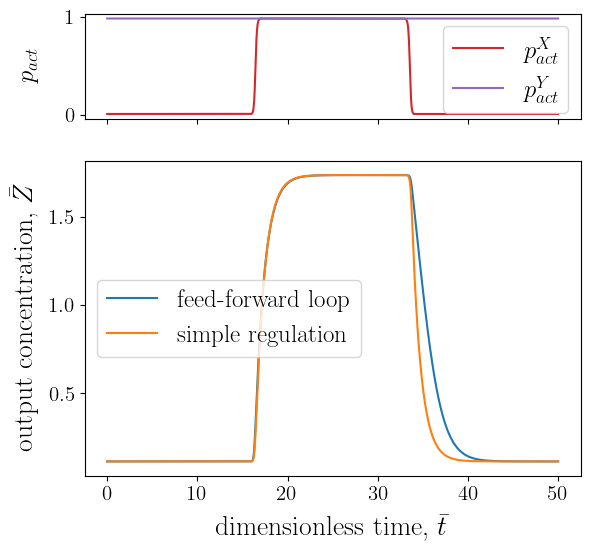

In [20]:
rys = [0, 2]
rzs = [0, 2, 20]
w = 0
Ks = [1, 0.2, 0.6]

nc = 1000
integrate_coherent_continuous(rys, rzs, w, Ks, nc)

### (B) Middle-speed tuning

The timescale of effector variation, tc, is 1.65.


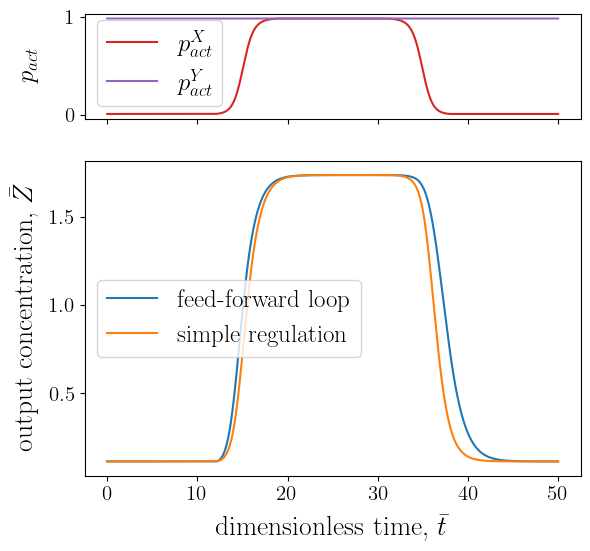

In [21]:
rys = [0, 2]
rzs = [0, 2, 20]
w = 0
Ks = [1, 0.2, 0.6]

nc = 7000
integrate_coherent_continuous(rys, rzs, w, Ks, nc)

### (C) Slow-speed tuning

The timescale of effector variation, tc, is 5.18.


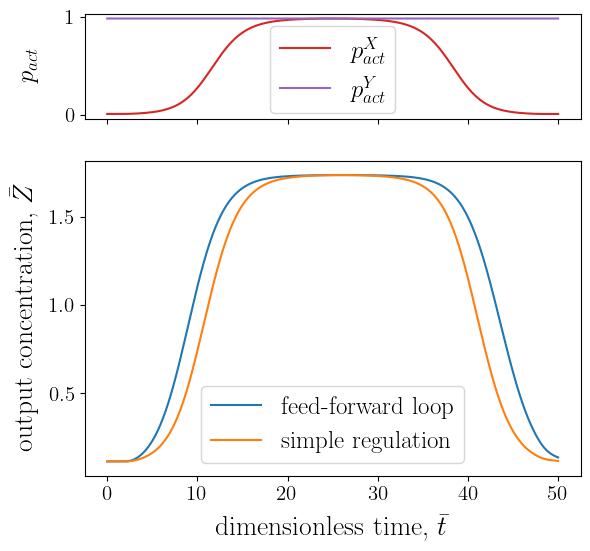

In [22]:
rys = [0, 2]
rzs = [0, 2, 20]
w = 0
Ks = [1, 0.2, 0.6]

nc = 22000
integrate_coherent_continuous(rys, rzs, w, Ks, nc)

# Appendix Figures

# Fig. 35

This figure systematically sweeps over $(\bar{K}_{YZ}, \bar{K}_{XZ})$ parameter space for the difference $\Delta\bar{Z} = \bar{Z}_{max} - \bar{Z}_{min}$. Each plot evaluates this difference for one of the three logic gates discussed in the paper.

In [23]:
def delZ_colormap(rys, rzs, w, Kxzs, Kyzs, plow=pAct(10**(-4)), phigh=pAct(10**(-7)), X=1):
    """ Sweep in (KXZ, KYZ) space and compute Delta Z

    Arguments:
        - rys: [r0Y, r1Y], production rates of Y
        - rzs: [r0Z, r1Z, r2Z], production rates of Z
        - w: cooperativity
        - Kxzs: array of Kxz to be swept
        - Kyzs, array of Kyz to be swept
        - plow: low value of pact^X
        - phigh: high value of pact^X
        - X: dimensionless concentration of X
        - plot: whether to plot the heatmap
    """

    # Create 2d mesh
    KX, KY = np.meshgrid(Kxzs, Kyzs)
    KXY = np.full_like(KX, 1)
    Ks = [KXY, KX, KY]

    Xs = np.full_like(KX, X)

    # Compute initial and final FFL steady states
    [_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
    [_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

    # Take the difference to find Delta Z
    delZ = highZ - lowZ

    # Plot
    
    fig, ax = plt.subplots()
    im = ax.pcolormesh(KX, KY, delZ, cmap="Greens", rasterized = True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$\bar{K}_{XZ}$")
    ax.set_ylabel(r"$\bar{K}_{YZ}$")
    cbar = plt.colorbar(im)
    cbar.set_label(r"$\Delta \bar{Z}$")
    plt.show()

### (A): XOR gate

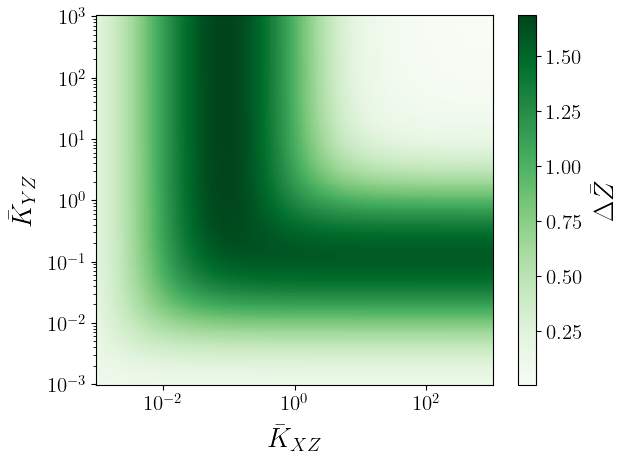

In [24]:
rys = [0, 2]
rzs = [0, 2, 0]
w = 0

length = 200

# Create 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

# Plot
delZ_colormap(rys, rzs, w, Kxzs, Kyzs)

### (B): AND gate

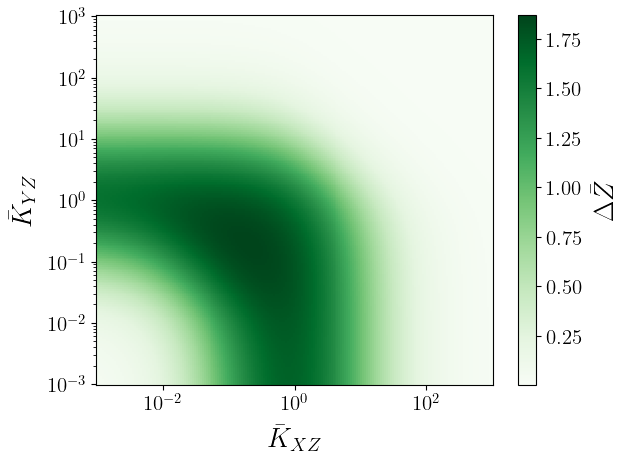

In [25]:
rys = [0, 2]
rzs = [0, 0, 2]
w = 10

length = 200

# Create 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

# Plot
delZ_colormap(rys, rzs, w, Kxzs, Kyzs)

### (C): OR gate

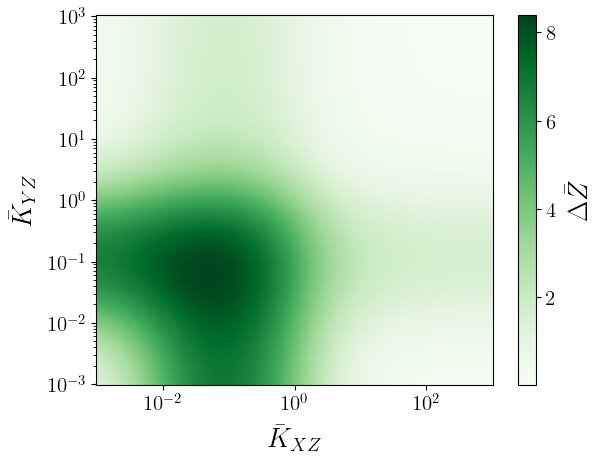

In [26]:
rys = [0, 2]
rzs = [0, 2, 10]
w = 1

length = 200

# Create 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

# Plot
delZ_colormap(rys, rzs, w, Kxzs, Kyzs)

# Fig. 36

This figure systematically sweeps across $(\bar{K}_{XZ}, \bar{K}_{YZ})$ space for all possible pairs of tunable parameters in coherent feed-forward loops. The resulting heatmaps track the maximum magnitude for the average time delay observed, i.e., $|\langle\Delta\bar{t}\rangle|_{max}$. Note that, unless being evaluated in a heatmap, rate, cooperativity, and input parameters are fixed at $\bar{r}_{0Y} = \bar{r}_{0Z} = \bar{r}_{0} = 0$, $\bar{r}_{1Y}  = \bar{r}_{1Z} = \bar{r}_1 = 1$, $\bar{r}_{2Z} = 5$, $\omega = 5$, $\bar{X} = 1$. Note that we set $\bar{r}_{0Y}  = \bar{r}_{0Z}$ and $\bar{r}_{1Y}  = \bar{r}_{1Z}$ to decrease the number of degrees of freedom in the parameter space without losing too much information.

## Helper function

In [27]:
length = 20
default_params = np.array([0, 1, 5, 5, 1], dtype=float)
labels = [r"$\bar{r}_0$", r"$\bar{r}_1$", r"$\bar{r}_2$",
          r"$\omega$", r"$\bar{X}$"]

def delt_sweep_OFF(default_params, sweep_params, labels, where, length=20,
                   Kxzs=np.logspace(-3, 3, 100), Kyzs=np.logspace(-3, 3, 100),
                   plow=pAct(10**(-4)), phigh=pAct(10**(-7)),
                   xlog=False, ylog=False, vmin=0, vmax=5):
    """ Sweep across 4 parameters at a time,
    including two parameters of choice and (KXZ, KYZ),
    and then compute average time delay in coherent FFL
    
    Arguments:
        - default_params: default set of parameters
            [r0, r1, r2, w, X]
        - sweep_params: list of parameter arrays to be swept
        - labels: labels for each parameter
        - where: position of the parameters to be swept
        - length: length of parameter sweep array
        - Kxzs: array of Kxz to be swept
        - Kyzs: array of Kyz to be swept
        - plow: low value of pact^X
        - phigh: high value of pact^X
        - xlog: plot the x-axis in log scale if True
        - ylog: plot the y-axis in log scale if True
        - vmin: minimal value for colorbar
        - vmax: maximal value for colorbar
    """
    m, n = where
    sweep1 = sweep_params[m]
    sweep2 = sweep_params[n]
    S1, S2 = np.meshgrid(sweep1, sweep2)

    max_delt = np.zeros_like(S1)

    params = np.copy(default_params)

    for i in range(length):
        for j in range(length):
            params[m] = S1[i, j]
            params[n] = S2[i, j]
            r0, r1, r2, w, X = np.copy(params)
            max_delt[i, j] = delt_colormap_OFF([r0, r1], [r0, r1, r2], w, 
                                               Kxzs, Kyzs, plow, phigh, X, plot=False)
            
    fig, ax = plt.subplots()
    im = ax.pcolormesh(S1, S2, max_delt, cmap="Greens", rasterized = True, vmin=vmin, vmax=vmax)
    if xlog:
        ax.set_xscale("log")
    if ylog:
        ax.set_yscale("log")
    plt.xlabel(labels[m])
    plt.ylabel(labels[n])
    cbar = plt.colorbar(im)
    cbar.set_label(r"$|\langle \Delta \bar{t} \rangle|_{max}$")
    plt.show()
    print(f"Maximal time delay found is {np.max(max_delt)}")

## Parameter sweeps

In order, we are sweeping $(r_0, r_1)$, $(r_0, r_2)$, $(r_0, \omega)$, $(r_0, \bar{X})$, $(r_1, r_2)$, $(r_1, \omega)$, $(r_1, \bar{X})$, $(r_2, \omega)$, $(r_2, \bar{X})$, and $(\omega, \bar{X})$.

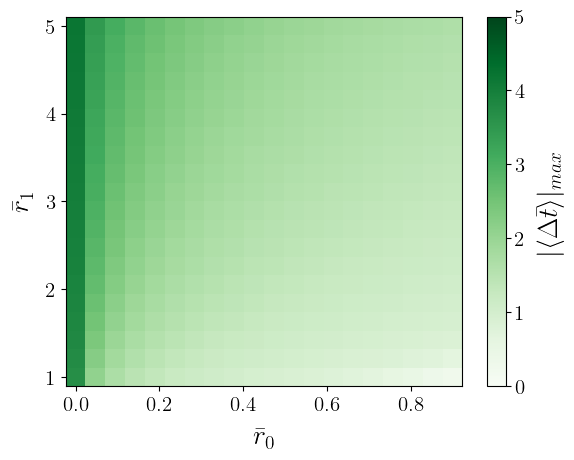

Maximal time delay found is 4.199150953046187


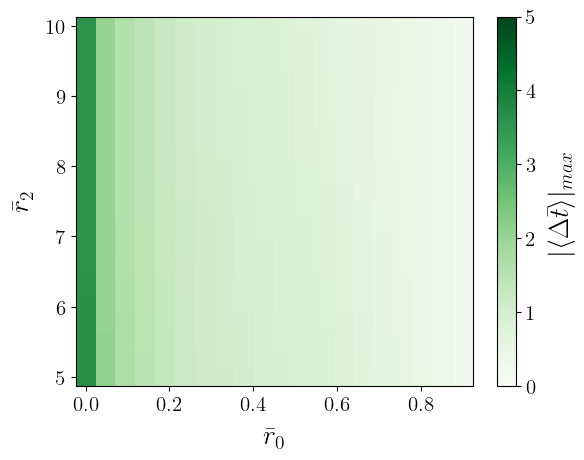

Maximal time delay found is 3.686839041357649


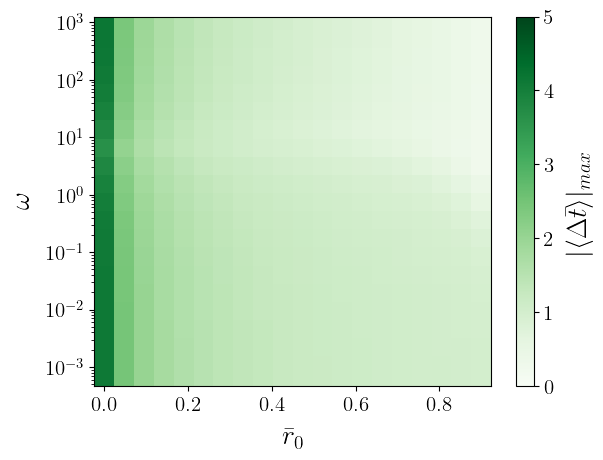

Maximal time delay found is 4.169796003054271


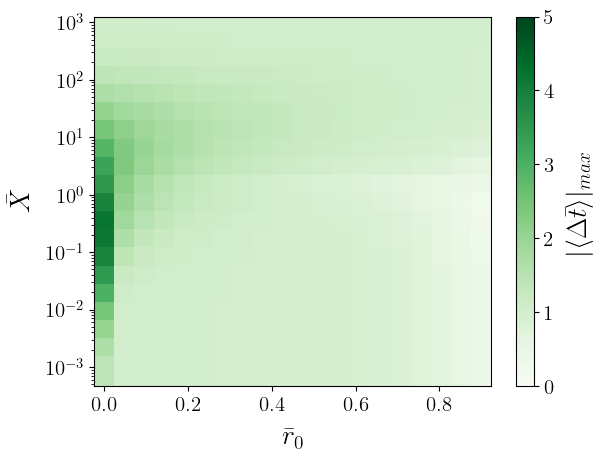

Maximal time delay found is 4.20020116029027


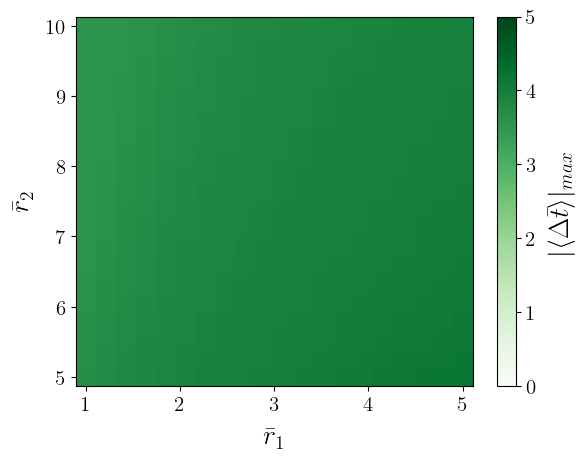

Maximal time delay found is 4.199150953046187


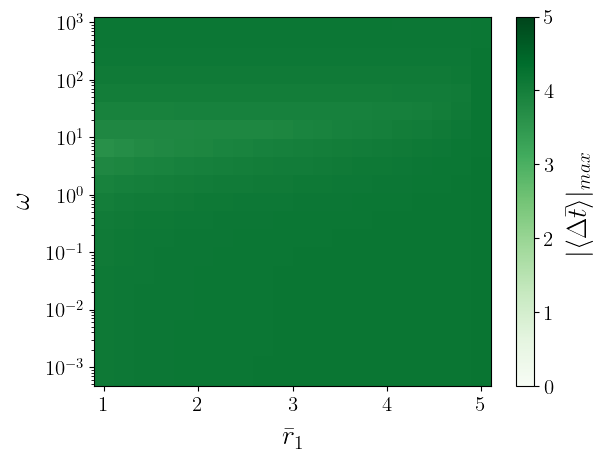

Maximal time delay found is 4.199461053694709


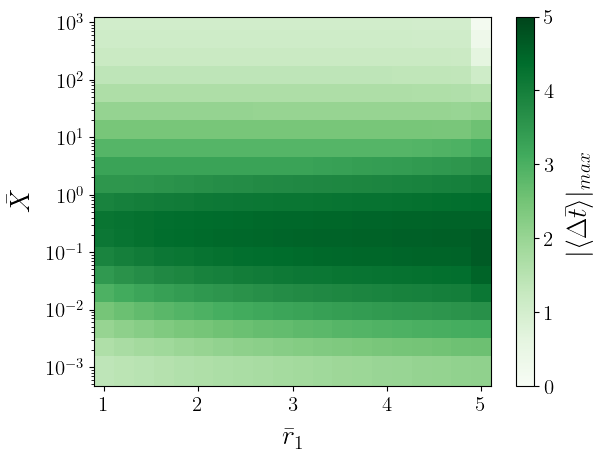

Maximal time delay found is 4.637267009525095


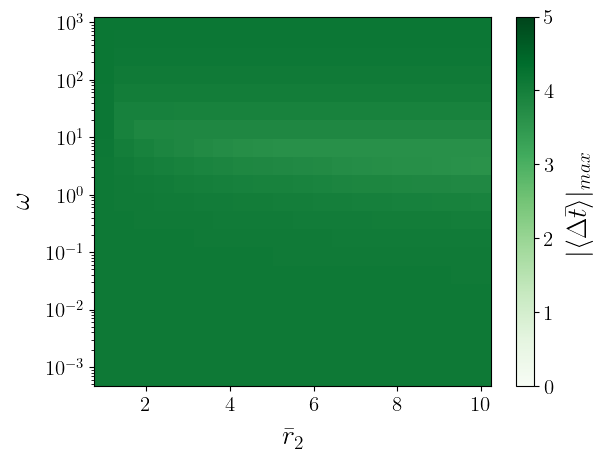

Maximal time delay found is 4.1703295849119275


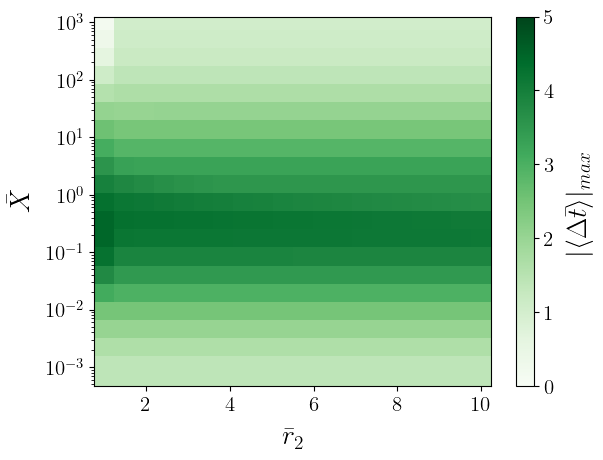

Maximal time delay found is 4.4686454193305245


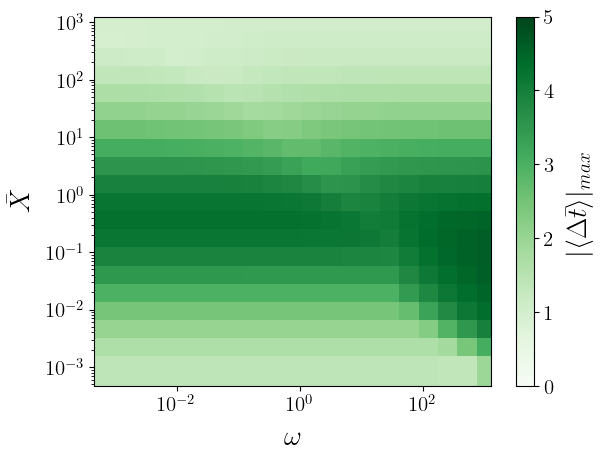

Maximal time delay found is 4.608557009923977


In [28]:
r0s = np.linspace(0, 0.9, length)
r1s = np.linspace(1, 5, length)
r2s_vert = np.linspace(5, 10, length)
r2s_hor = np.linspace(1, 10, length)
ws = np.logspace(-3, 3, length)
xs = np.logspace(-3, 3, length)

sweep_params1 = [r0s, r1s, r2s_vert, ws, xs]
sweep_params2 = [r0s, r1s, r2s_hor, ws, xs]

# r0, r1
where = np.array([0, 1], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where)

# r0, r2
where = np.array([0, 2], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where)

# r0, w
where = np.array([0, 3], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, ylog=True)

# r0, X
where = np.array([0, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, ylog=True)

# r1, r2
where = np.array([1, 2], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where)

# r1, w
where = np.array([1, 3], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, ylog=True)

# r1, X
where = np.array([1, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, ylog=True)

# r2, w
where = np.array([2, 3], dtype=int)
delt_sweep_OFF(default_params, sweep_params2, labels, where, ylog=True)

# r2, X
where = np.array([2, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params2, labels, where, ylog=True)

# w, X
where = np.array([3, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params2, labels, where, xlog=True, ylog=True)

# Fig. 37

This figure demonstrates the effect of leakiness in $p_{act}^X(c_{X})$ on the average time delay $\langle\Delta\bar{t}\rangle|$. Specifically, for the XOR logic gate, we sweep across $(\bar{r}_{1},\bar{X})$ parameter space (fixing $\bar{r}_{0} = 0$ and $\omega = 0$) and plot how $|\langle\Delta\bar{t}\rangle|_{max}$ changes as the minimum possible probability for input activity, $p_{min}$, decreases.

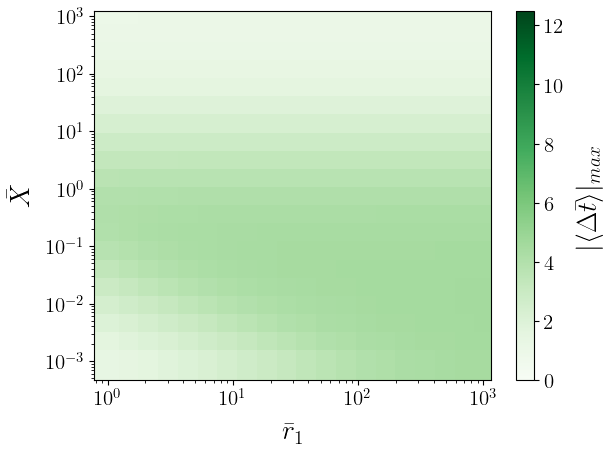

Maximal time delay found is 4.547287720859733


In [29]:
length = 20
default_params = np.array([0, 1, 5, 0, 1], dtype=float)
labels = [r"$\bar{r}_0$", r"$\bar{r}_1$", r"$\bar{r}_2$",
          r"$\omega$", r"$\bar{X}$"]

r1s = np.logspace(0, 3, length)
xs = np.logspace(-3, 3, length)

sweep_params1 = [r0s, r1s, r2s_vert, ws, xs]
sweep_params2 = [r0s, r1s, r2s_hor, ws, xs]

# pmin = 10^(-2)

where = np.array([1, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, plow=10**(-2),
               xlog=True, ylog=True, vmin=0, vmax=12.5)

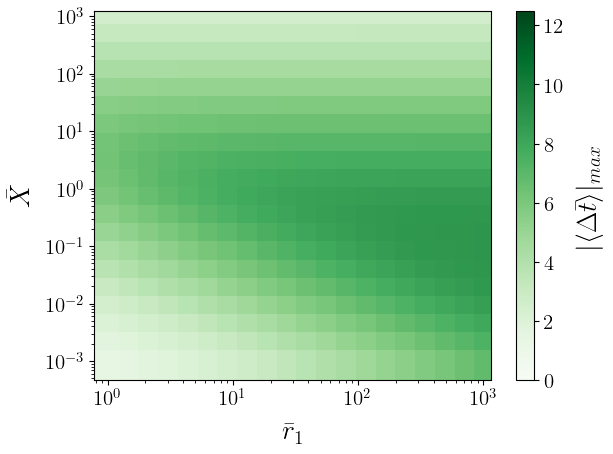

Maximal time delay found is 8.878343717963112


In [30]:
# pmin = 10^(-4)

where = np.array([1, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, plow=10**(-4),
               xlog=True, ylog=True, vmin=0, vmax=12.5)

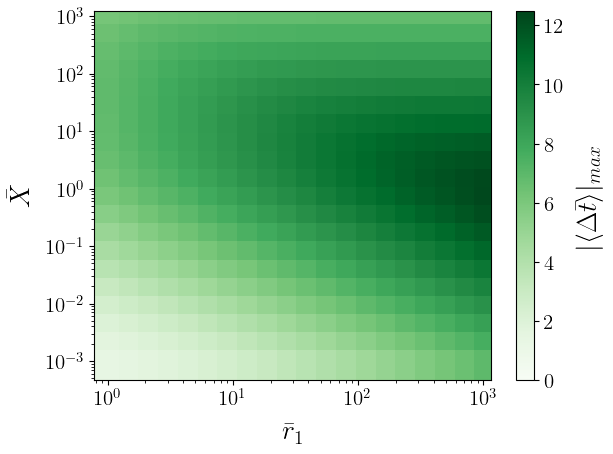

Maximal time delay found is 12.308807602521764


In [31]:
# pmin = 10^(-6)

where = np.array([1, 4], dtype=int)
delt_sweep_OFF(default_params, sweep_params1, labels, where, plow=10**(-6),
               xlog=True, ylog=True, vmin=0, vmax=12.5)

# Fig. 38

$\bar{Y} = 0.01$

The timescale of effector variation, tc, is 0.24.


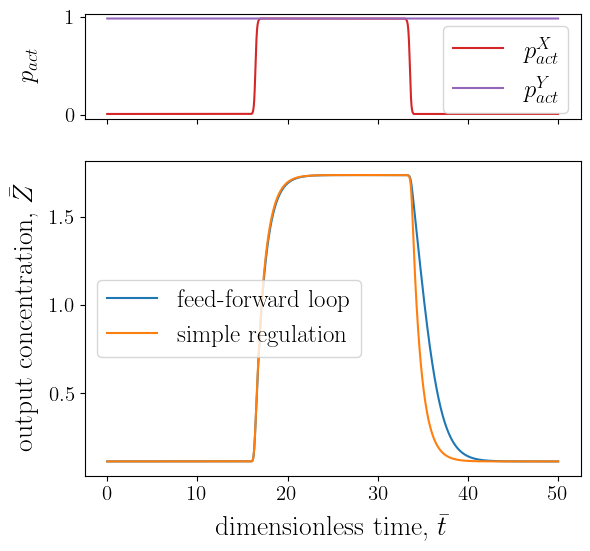

The timescale of effector variation, tc, is 1.65.


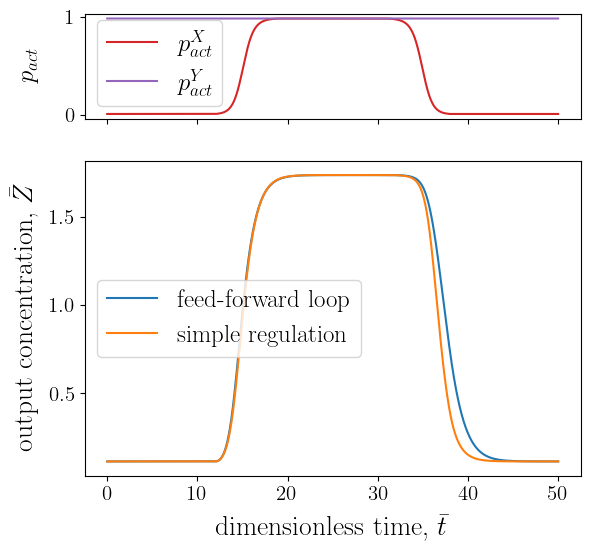

The timescale of effector variation, tc, is 5.18.


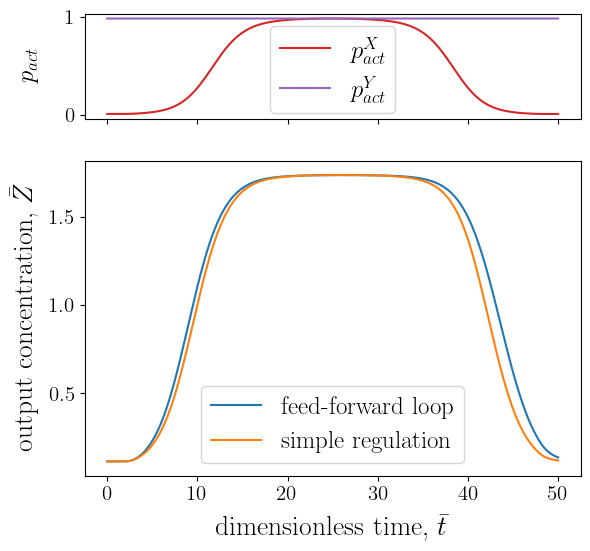

In [32]:
rys = [0, 2]
rzs = [0, 2, 20]
w = 0
Ks = [1, 0.2, 0.6]

# fast
nc = 1000
integrate_coherent_continuous(rys, rzs, w, Ks, nc, Y=0.01)
# middle
nc = 7000
integrate_coherent_continuous(rys, rzs, w, Ks, nc, Y=0.01)
# slow
nc = 22000
integrate_coherent_continuous(rys, rzs, w, Ks, nc, Y=0.01)

$\bar{Y} = 100$

The timescale of effector variation, tc, is 0.24.


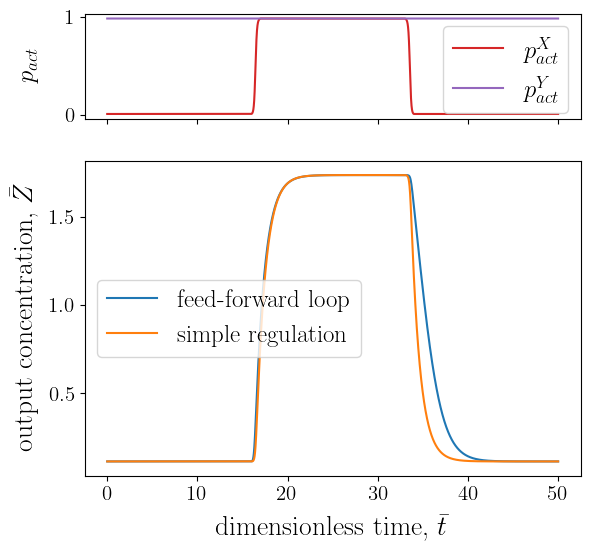

The timescale of effector variation, tc, is 1.65.


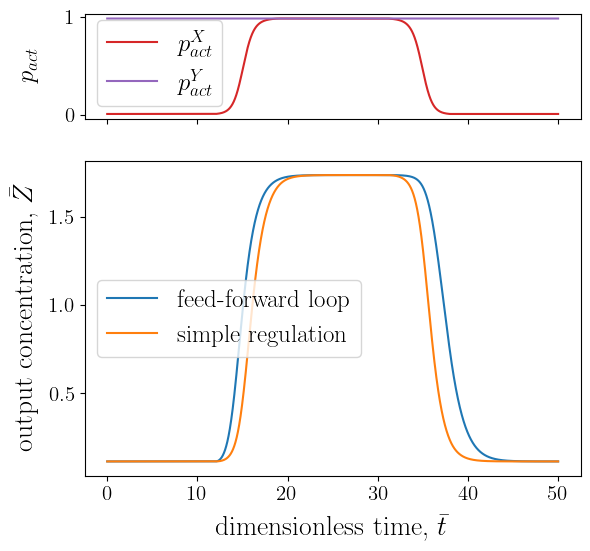

The timescale of effector variation, tc, is 5.18.


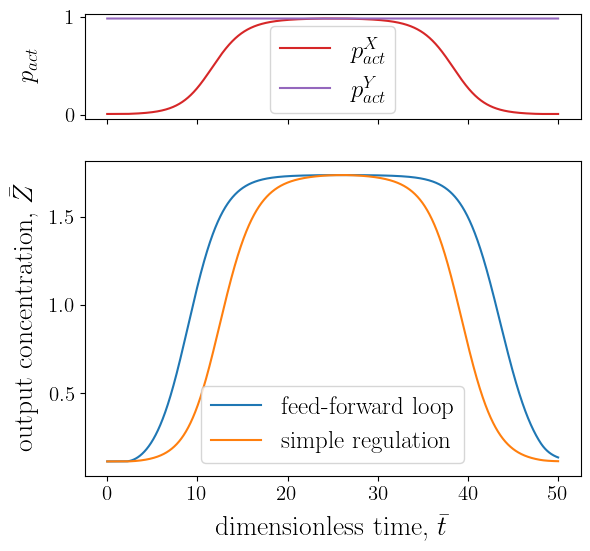

In [33]:
rys = [0, 2]
rzs = [0, 2, 20]
w = 0
Ks = [1, 0.2, 0.6]

# fast
nc = 1000
integrate_coherent_continuous(rys, rzs, w, Ks, nc, Y=100)
# middle
nc = 7000
integrate_coherent_continuous(rys, rzs, w, Ks, nc, Y=100)
# slow
nc = 22000
integrate_coherent_continuous(rys, rzs, w, Ks, nc, Y=100)